<a href="https://colab.research.google.com/github/teedonk/Image-classification-with-Transfer-Learning/blob/main/cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import required libraries
import numpy as np
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [ ]:
#import libraries for file access
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
#Download files
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"10frChX6he0sqLY1j7V1iWgBFFzaje8TL"})
downloaded.GetContentFile('train.zip')

In [ ]:
#Create directory and unpack the zip file
try:
 os.mkdir('Data')
 os.mkdir('Data/CatsDogs')
 os.mkdir('Data/CatsDogs/trn')
 os.mkdir('Data/CatsDogs/trn/dogs')
 os.mkdir('Data/CatsDogs/trn/cats')
 os.mkdir('Data/CatsDogs/val')
 os.mkdir('Data/CatsDogs/val/dogs')
 os.mkdir('Data/CatsDogs/val/cats')
 os.mkdir('Data/CatsDogs/tst')
 os.mkdir('Data/CatsDogs/tst/dogs')
 os.mkdir('Data/CatsDogs/tst/cats')
except OSError:
 pass
train_dir = 'Data/CatsDogs/trn'
val_dir = 'Data/CatsDogs/val'
test_dir = 'Data/CatsDogs/tst'
!unzip train.zip -d Data/CatsDogs > /dev/null

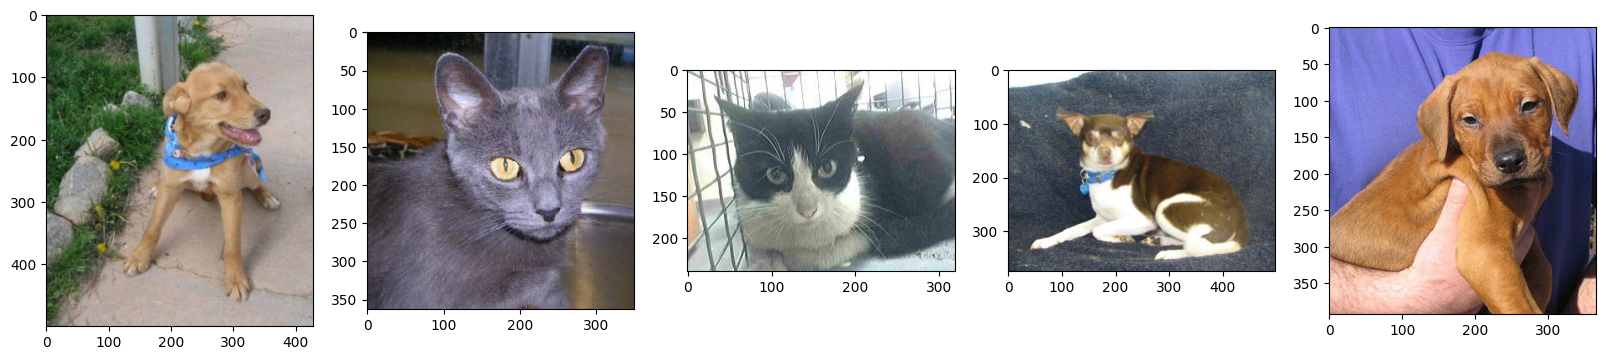

In [ ]:
#plot few images
%matplotlib inline
images = [f'Data/CatsDogs/train/{i}' for i in
os.listdir('Data/CatsDogs/train')]
plt.figure(figsize=(20, 10))
cols = 5
for i in range(cols):
 plt.subplot(int(5 / cols+1), cols, i+1)
 plt.imshow(mpimg.imread(images[i]))

In [ ]:
#Get the list of the images
unpack_dir = 'Data/CatsDogs/train'
tr_imgs = [f'{i}' for i in os.listdir(unpack_dir)]
np.random.shuffle(tr_imgs)
trainratio = 0.75
valratio = 0.1
train = int(len(tr_imgs) * trainratio)
val = int(len(tr_imgs) * valratio)

In [ ]:
#Move the files to the directories
def move_images(imgs, firstimage, lastimage, source, destination):
 for fnam in imgs[firstimage:lastimage]:
  srcfile = source + '/' + fnam
  if 'dog' in fnam:
    destfile = destination + '/dogs/' + fnam
  else:
    destfile = destination + '/cats/' + fnam
  os.replace(srcfile, destfile)
move_images(tr_imgs, 0, train, unpack_dir, train_dir)
move_images(tr_imgs, train, train + val, unpack_dir, val_dir)
move_images(tr_imgs, train + val, len(tr_imgs), unpack_dir, test_dir)

In [ ]:
print('Dogs in training set ', len(os.listdir(train_dir + '/dogs')))
print('Cats in training set ', len(os.listdir(train_dir + '/cats')))
print('Dogs in validation set ', len(os.listdir(val_dir + '/dogs')))
print('Cats in validation set ', len(os.listdir(val_dir + '/cats')))
print('Dogs in test set ', len(os.listdir(test_dir + '/dogs')))
print('Cats in test set ', len(os.listdir(test_dir + '/cats')))

Dogs in training set  9371
Cats in training set  9379
Dogs in validation set  1210
Cats in validation set  1290
Dogs in test set  1919
Cats in test set  1831


In [ ]:
 #ImageDataGenerators set up

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
batch_size = 32
trn_data = ImageDataGenerator(rescale=1/255,
 rotation_range=40,
 width_shift_range=0.2,
 height_shift_range=0.2,
 shear_range=0.2,
 zoom_range=0.2,
 horizontal_flip=True)
valtst_data = ImageDataGenerator(rescale=1/255)
trn_gen = trn_data.flow_from_directory(train_dir, batch_size=batch_size,
class_mode='binary', target_size=(150,150))
val_gen = valtst_data.flow_from_directory(val_dir, batch_size=batch_size,
class_mode='binary', target_size=(150,150))
tst_gen = valtst_data.flow_from_directory(test_dir, batch_size=batch_size,
class_mode='binary', target_size=(150,150), shuffle=False)

Found 18750 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


In [ ]:
#import model from keras

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import layers, models

def gen_model():
 base=InceptionResNetV2(weights='imagenet',
 include_top=False,
 input_shape=(150, 150, 3))
 model = models.Sequential()
 model.add(base)
 model.add(layers.Flatten())
 model.add(layers.Dense(256, activation='relu'))
 model.add(layers.Dense(2, activation='softmax'))
 base.trainable = False
 return model

In [ ]:
model = gen_model()
model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 3, 3, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 13824)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,539,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,876,450 (220.78 MB)

 Trainable params: 3,539,714 (13.50 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [ ]:
from tensorflow.keras import optimizers
epochs = 3
model.compile(loss='sparse_categorical_crossentropy',
 optimizer=optimizers.Adam(learning_rate=2e-5),
 metrics=['acc'])
hist = model.fit(trn_gen, validation_data=val_gen,
 epochs=epochs)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


586/586 ━━━━━━━━━━━━━━━━━━━━ 214s 311ms/step - acc: 0.9118 - loss: 0.2339 - val_acc: 0.9696 - val_loss: 0.0865
Epoch 2/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 154s 261ms/step - acc: 0.9419 - loss: 0.1400 - val_acc: 0.9720 - val_loss: 0.0789
Epoch 3/3
586/586 ━━━━━━━━━━━━━━━━━━━━ 238s 323ms/step - acc: 0.9478 - loss: 0.1294 - val_acc: 0.9724 - val_loss: 0.0880


In [ ]:
#performance check

pr_yclass = model.predict(tst_gen)
pr_y = np.argmax(pr_yclass, axis=1)
true_y = tst_gen.classes
print("Accuracy ",(pr_y==true_y).sum()/len(true_y))
tf.math.confusion_matrix(true_y, pr_y)

118/118 ━━━━━━━━━━━━━━━━━━━━ 36s 203ms/step
Accuracy  0.9669333333333333


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1735,   96],
       [  28, 1891]], dtype=int32)>

rows = 25 cols = 5


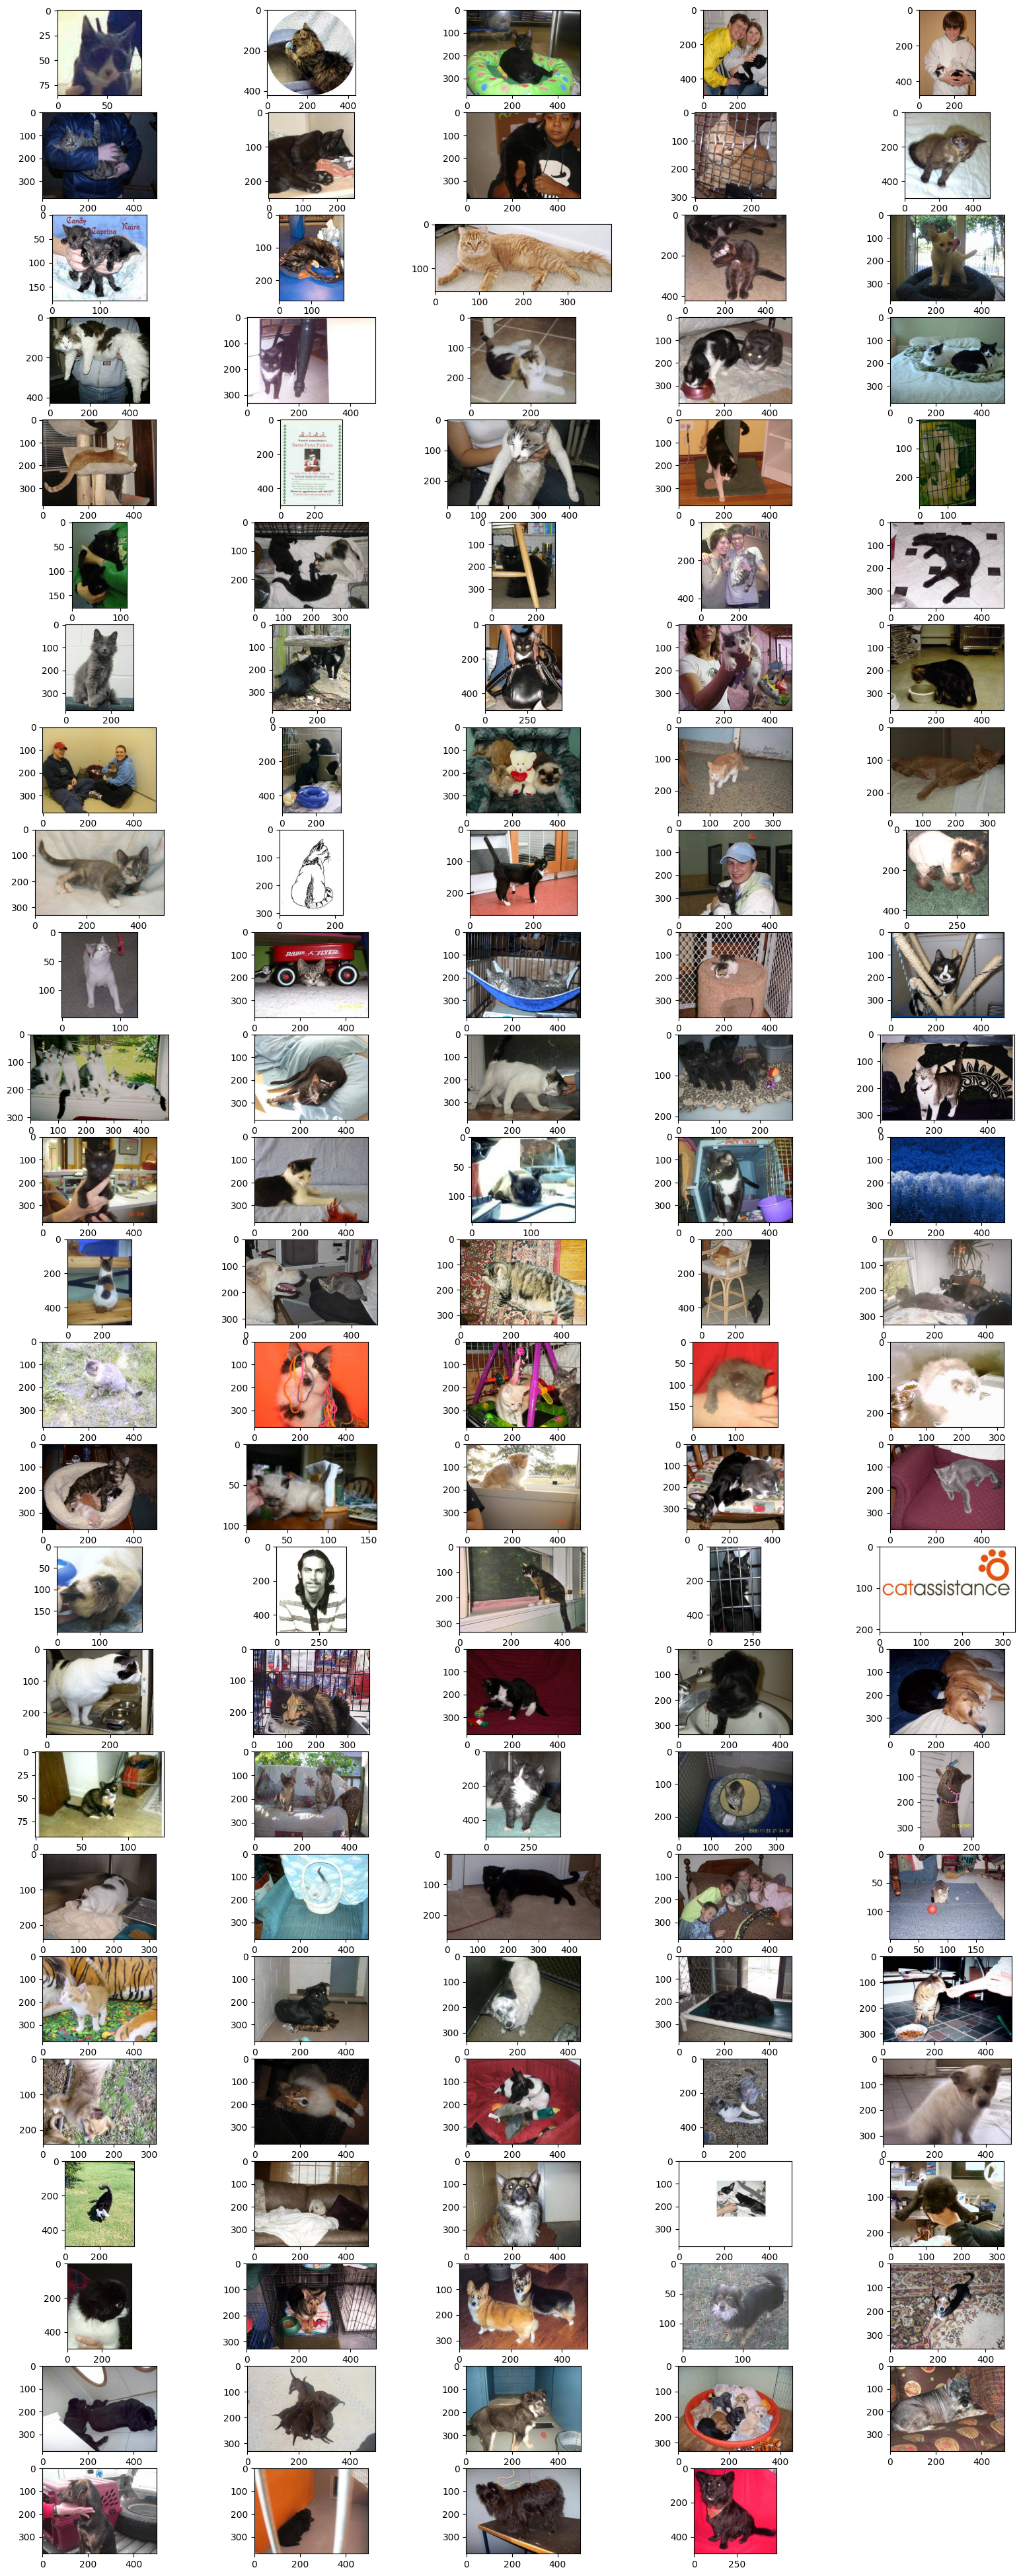

In [ ]:
#View misclassified images
badresults = np.where((pr_y != true_y))
cols = 5
col = 1
rows = int(len(badresults[0])/cols)+1
print("rows =",rows,"cols =",cols)
plt.figure(figsize=(20, 50))
for i in badresults[0]:
 plt.subplot(rows, cols, col)
 plt.imshow(mpimg.imread('Data/CatsDogs/tst/' +
tst_gen.filenames[i]))
 col += 1